## Estimate Uncertainty using Bayesian Posterior
Assume the flat prior beta(1,1). We have a binomial process with n success and m failures. Then the posterior is beta(n+1,m+1). This is just standard bayesian A/B testing.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import bernoulli, beta
from datetime import datetime, timedelta
sns.set_style('whitegrid')
%matplotlib inline

## Read in Data
- Redacted

### Build tableau color palette

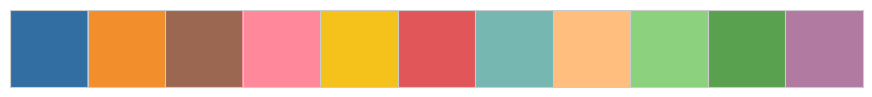

In [5]:
tableau_palette = ["#326ea1", "#f28e2b", "#9c6751","#ff899b", "#f5c21b", 
                   "#e15759", "#76b7b2","#FFBE7D","#8CD17D","#59a14f",
                  "#b07aa1"]
color_codes_wanted = ['tableau_blue', 'tableau_orange','tableau_brown', 'tableau_pink', 'tableau_yellow',
                      'tableau_red','tableau_teal', 'tableau_beige','tableau_light_green',
                     'tableau_dark_green','tableau_purple']

c = lambda x: tableau_palette[color_codes_wanted.index(x)]


color_dict = {'Advanced':c("tableau_blue"),'Standard':c('tableau_brown'),'Direct':c('tableau_pink'),
              'Value':c('tableau_yellow'),'Advanced & Value':c('tableau_light_green'),
              'Advanced, Standard, Value':c('tableau_beige'),'Control':c('tableau_dark_green'),
             'Advanced & Standard':c('tableau_red'),'Value & Standard':c('tableau_purple')}

sns.palplot(tableau_palette)

## Each day, aggregate the results and update the posterior 
The posterior is just binom(n+1,m+1) where n is the number of successes and m is the number of failures

Date Range: 2022-08-24 2022-10-11
	Number of Records =  16302
	 Experience A: 4.02%
	 Experience B: 4.66%
	 Experience C: 4.84%


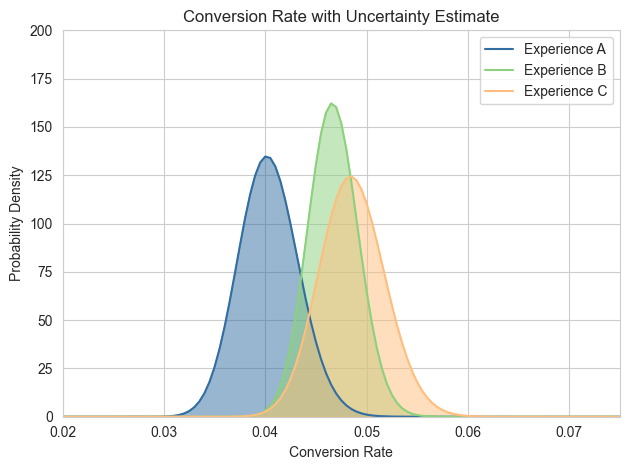

In [11]:
## Get test dates (should be the same as the data pull)
start_date = min(osu_results['Date'])
end_date = max(osu_results['Date'])
date_range = np.arange(start_date, end_date+timedelta(days=1), timedelta(days=1)).astype(datetime)

## Remap products to experiences for Portfolio purposes.
label_dict = {'Advanced':'Experience A','Advanced & Value':'Experience B','Advanced, Standard, Value':'Experience C'}

## set the parameter array
theta_array = np.linspace(0,0.1,201)

## Initialize params for flat prior: beta(a=1,b=1)
a = 1
b = 1

image_counter = 0
for each in date_range[-2:-1]:
    print("Date Range:",start_date,each.date())
    
    ## Get Visits and Signups
    results_to_date = osu_results[osu_results['Date'] <= each.date()]
    signups_to_date = results_to_date[~np.isnan(results_to_date['retainerID'])]
    
    ## Only keep online signups (no fog, no inbound call)
    signups_to_date = signups_to_date[(signups_to_date['UsuType']=='Oss:Parallel') | 
                                  (signups_to_date['UsuType']=='Oss:Snapshot')]
    
    print("\tNumber of Records = ",len(results_to_date))
    
    visits = results_to_date['Product_Offer'].value_counts()
    signups = signups_to_date['Product_Offer'].value_counts()
    
    ## For each product, calculate the posterior at this timestep (assuming flat prior beta(1,1))
    for product in ['Advanced','Advanced & Value','Advanced, Standard, Value']:
        
        if product in signups.keys():
            n_signups = signups[product]
        else:
            n_signups = 0
            
        n_visits = visits[product]
        conversion_rate = n_signups/n_visits*100
        print("\t",label_dict[product]+": {:.2f}%".format(conversion_rate))

        ## Plot beta distribution
        plt.plot(theta_array,beta.pdf(theta_array, a+n_signups, b+(n_visits-n_signups)),linestyle='-',
                 alpha=1.0,label=label_dict[product],color=color_dict[product])

        ## Shade region
        plt.fill_between(theta_array,beta.pdf(theta_array, a+n_signups, b+(n_visits-n_signups)),
                         color=color_dict[product],alpha=0.5)

    
    ## Plot
    plt.xlabel('Conversion Rate')
    plt.ylabel('Probability Density')
    plt.title("Conversion Rate with Uncertainty Estimate")
    plt.legend(loc='upper right')
    plt.xlim((0.02,0.075))
    plt.ylim((0,200))
    plt.tight_layout()
    plt.show()
#     plt.savefig('img/n_'+str(image_counter).rjust(6, '0')+'.pdf')
#     plt.cla()
    
    image_counter += 1  ## for simulation purposes